# Time series forecast predictions

In [1]:
# Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style
style.use('fivethirtyeight')

from tqdm import tqdm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import data
train1 = pd.read_csv("C:/Users/vaish/Documents/FYP  project/train_1.csv", parse_dates=True)
train2 = pd.read_csv("C:/Users/vaish/Documents/FYP  project/train_2.csv", parse_dates=True)

## Statistical tests

### Augmented Dickey-Fuller test

* This test checks if the data is stationary or not.
* It is a hypothesis testing in which the null hypothesis is that the data is non-stationary.
- **p-value > 0.05**: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
- **p-value <= 0.05**: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [3]:
name = []
for page in train1['Page']:
    split = page.split('.')
    name.append(split[-3])

train1['Name'] = name
train1['Language'] = train1['Name'].str[-2:]

In [4]:
from statsmodels.tsa.stattools import adfuller

def stationarity_test(timeseries, rolling_window, language):
    plt.figure(figsize=(50, 8))
    
    rolling_mean = pd.DataFrame.rolling(timeseries, window=rolling_window).mean()
    rolling_std = pd.DataFrame.rolling(timeseries, window=rolling_window).std()

    plt.plot(timeseries, color='blue', label= 'Original')
    plt.legend(loc='best')
    
    plt.plot(rolling_mean, color='red', label= 'Rolling Mean')
    plt.legend(loc='best')
    
    std = plt.plot(rolling_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    
    plt.title(f'Rolling Mean & Standard Deviation by Language : {language}')
    plt.show()
    
    # Dickey-Fuller test
    print('Results of Dickey-Fuller Test')
    print()
    test = adfuller(timeseries, autolag='AIC')
    output = pd.Series(test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
        output['Critical Value (%s)'%key] = value
    print(output)
    print('-'*100)

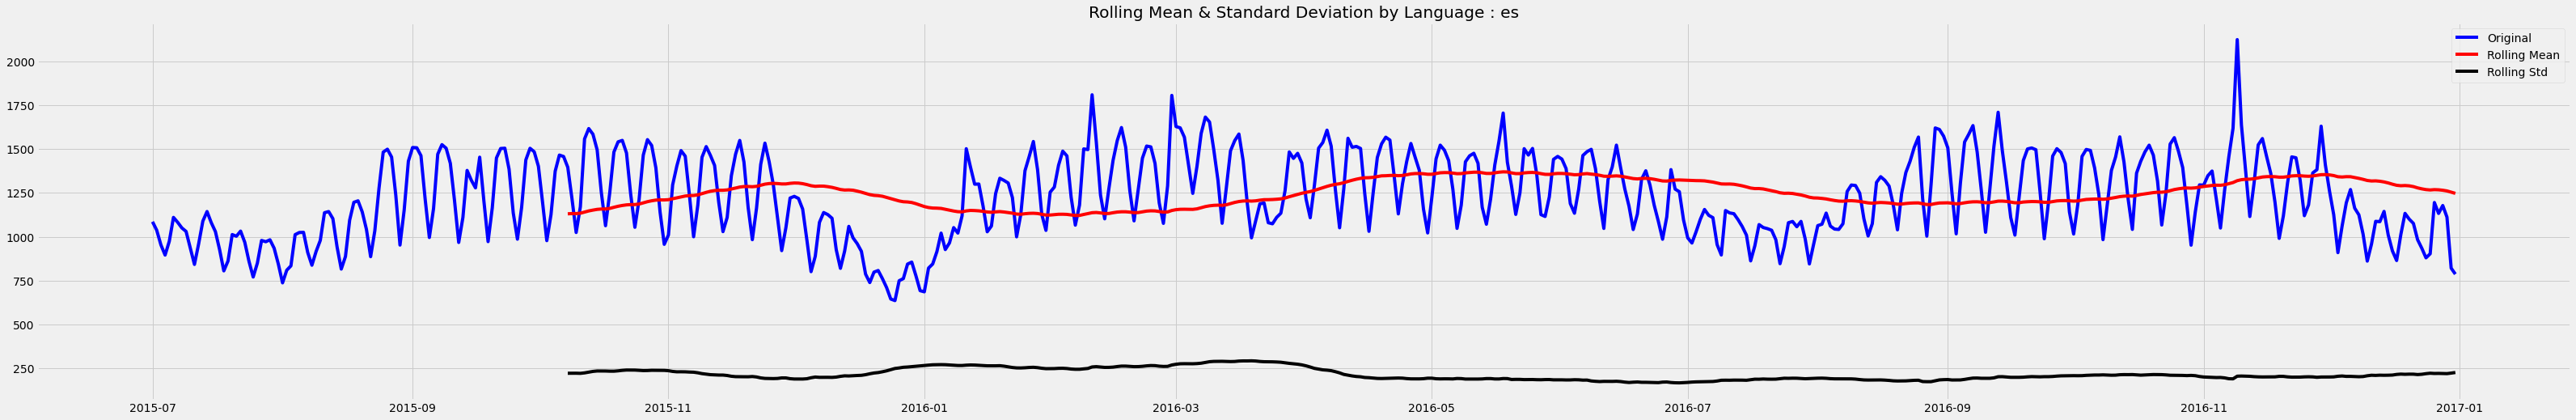

Results of Dickey-Fuller Test

Test Statistic                  -3.014209
p-value                          0.033589
#Lags Used                      15.000000
Number of Observations Used    534.000000
Critical Value (1%)             -3.442655
Critical Value (5%)             -2.866968
Critical Value (10%)            -2.569661
dtype: float64
----------------------------------------------------------------------------------------------------


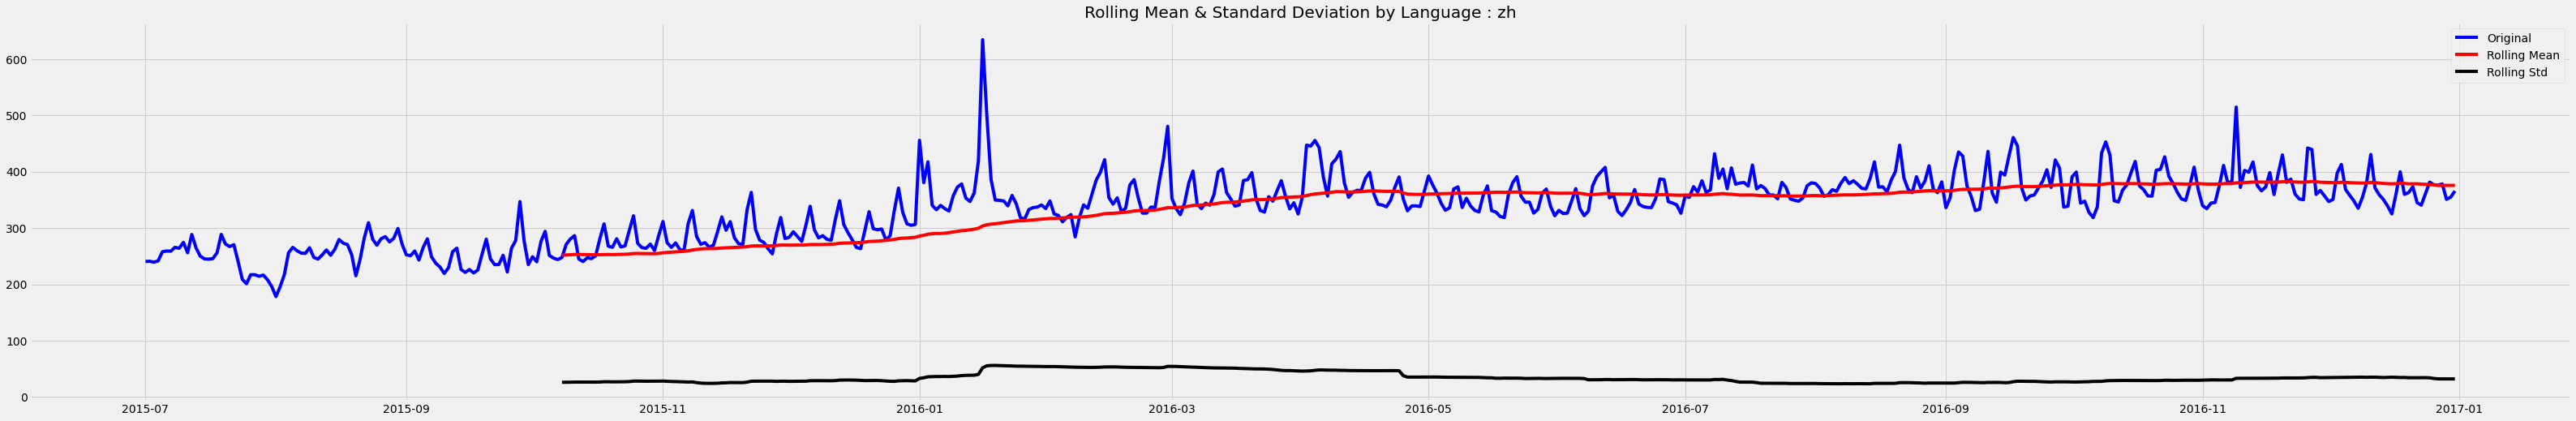

Results of Dickey-Fuller Test

Test Statistic                  -1.668433
p-value                          0.447446
#Lags Used                      19.000000
Number of Observations Used    530.000000
Critical Value (1%)             -3.442749
Critical Value (5%)             -2.867009
Critical Value (10%)            -2.569683
dtype: float64
----------------------------------------------------------------------------------------------------


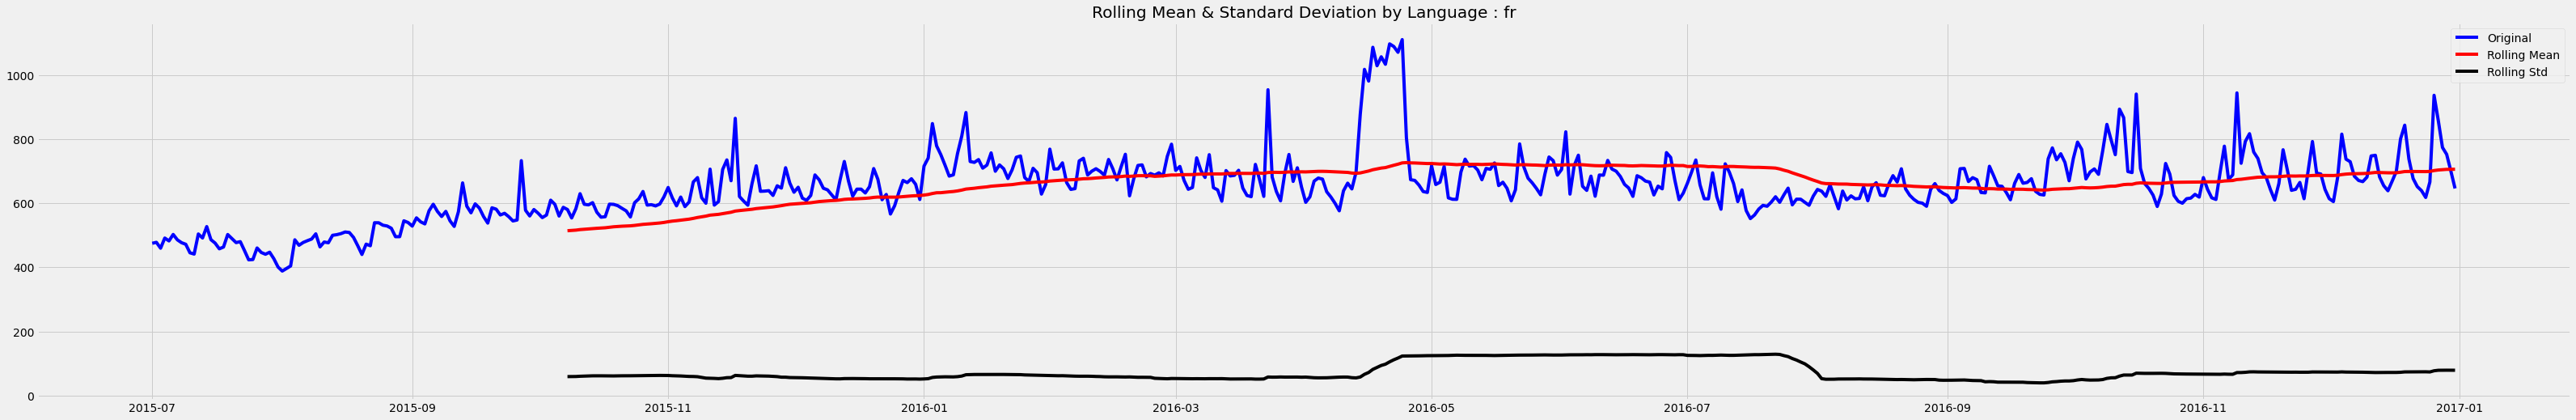

Results of Dickey-Fuller Test

Test Statistic                  -2.849875
p-value                          0.051495
#Lags Used                      13.000000
Number of Observations Used    536.000000
Critical Value (1%)             -3.442609
Critical Value (5%)             -2.866947
Critical Value (10%)            -2.569650
dtype: float64
----------------------------------------------------------------------------------------------------


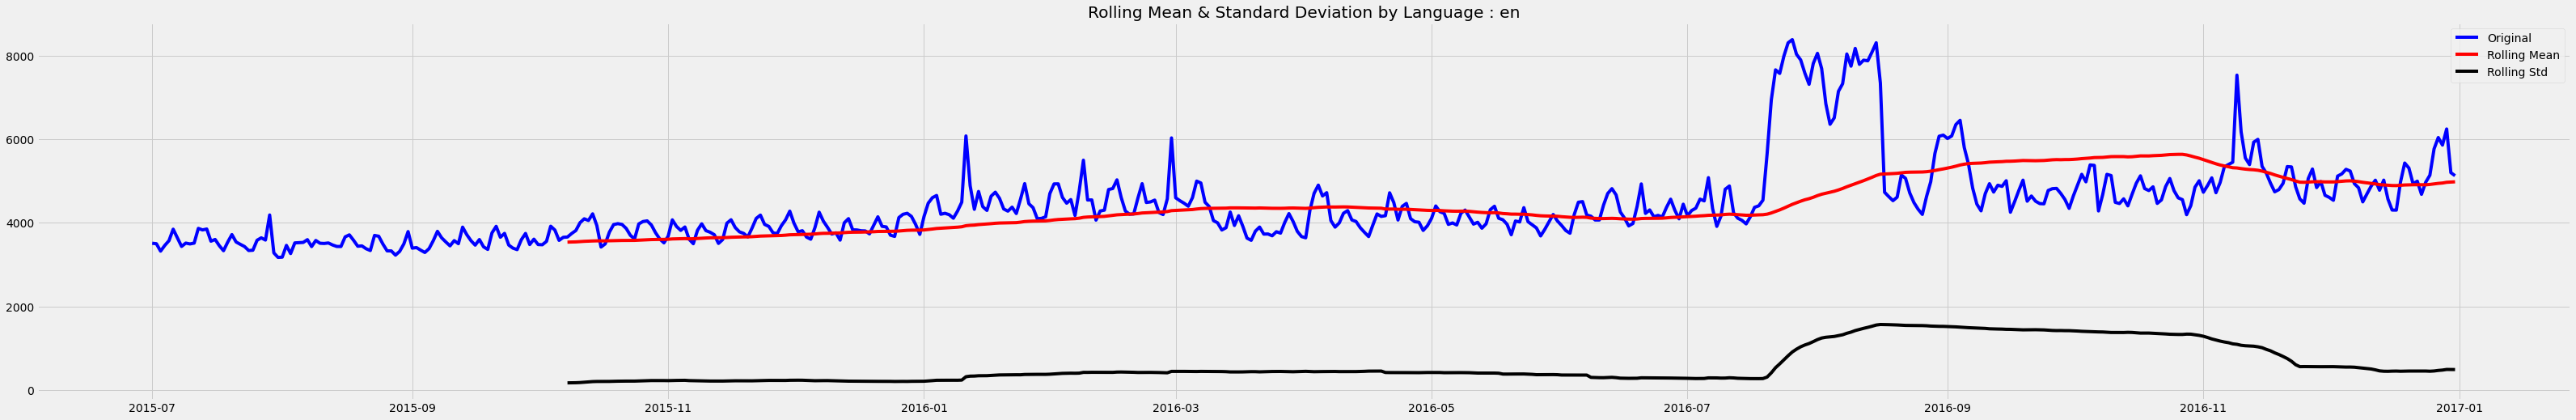

Results of Dickey-Fuller Test

Test Statistic                  -2.247284
p-value                          0.189534
#Lags Used                      14.000000
Number of Observations Used    535.000000
Critical Value (1%)             -3.442632
Critical Value (5%)             -2.866957
Critical Value (10%)            -2.569655
dtype: float64
----------------------------------------------------------------------------------------------------


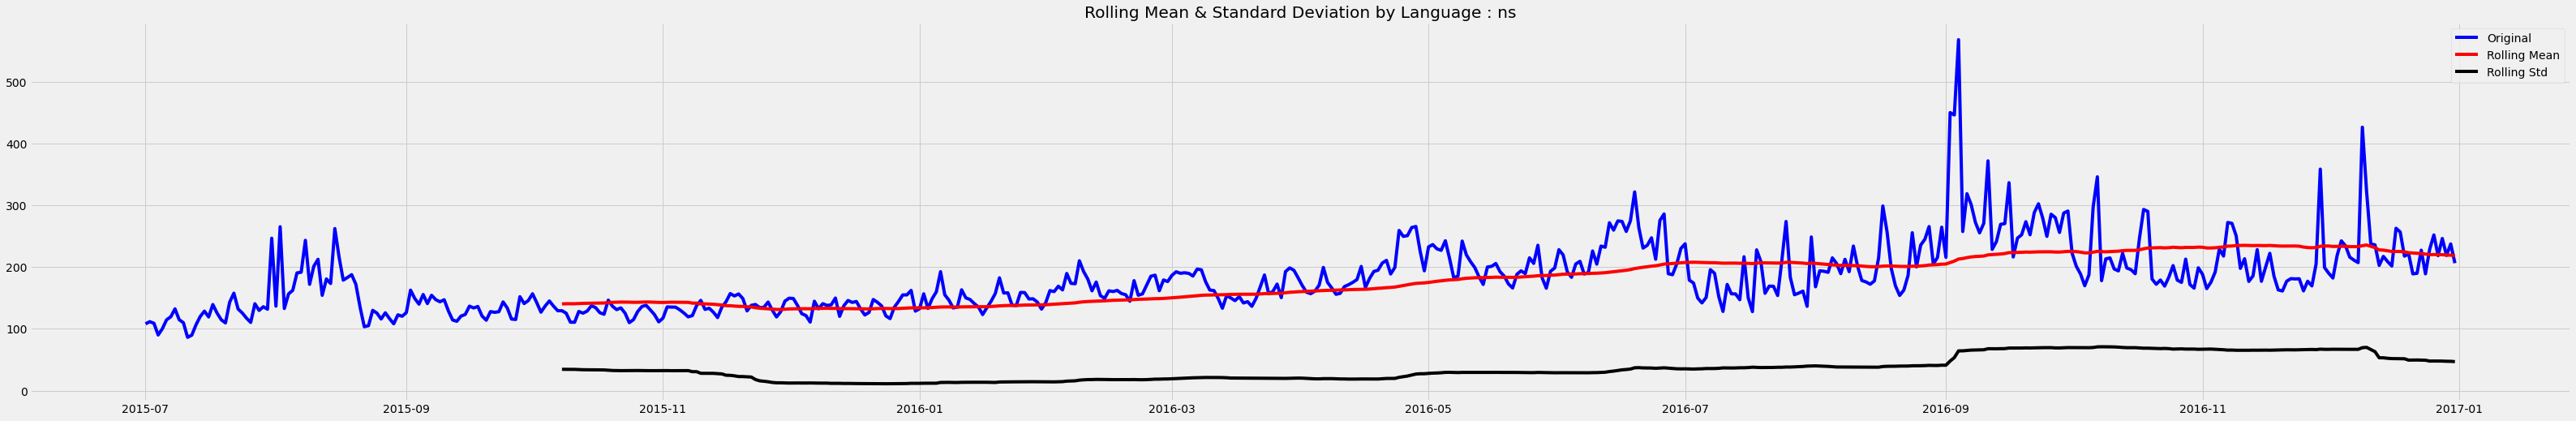

Results of Dickey-Fuller Test

Test Statistic                  -2.840219
p-value                          0.052754
#Lags Used                       6.000000
Number of Observations Used    543.000000
Critical Value (1%)             -3.442450
Critical Value (5%)             -2.866877
Critical Value (10%)            -2.569613
dtype: float64
----------------------------------------------------------------------------------------------------


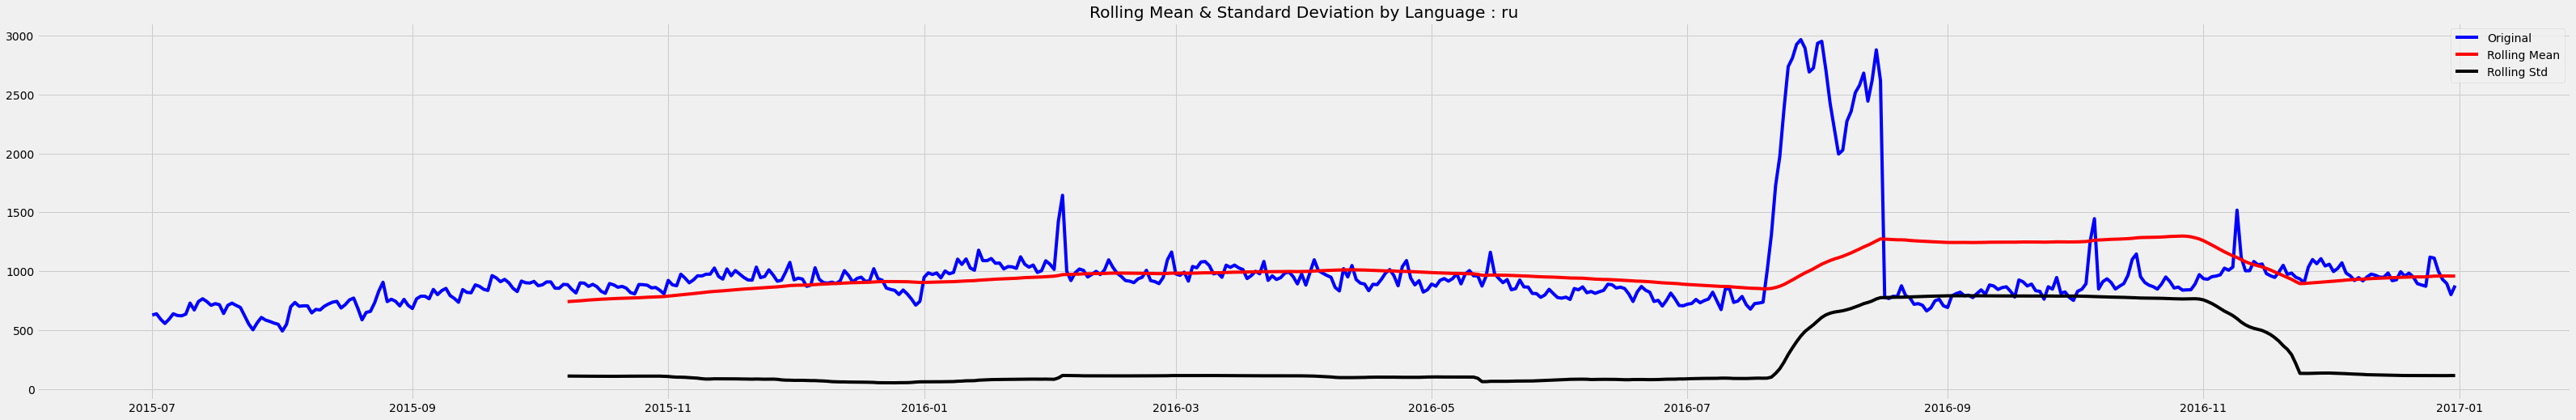

Results of Dickey-Fuller Test

Test Statistic                  -3.924031
p-value                          0.001865
#Lags Used                       3.000000
Number of Observations Used    546.000000
Critical Value (1%)             -3.442384
Critical Value (5%)             -2.866848
Critical Value (10%)            -2.569597
dtype: float64
----------------------------------------------------------------------------------------------------


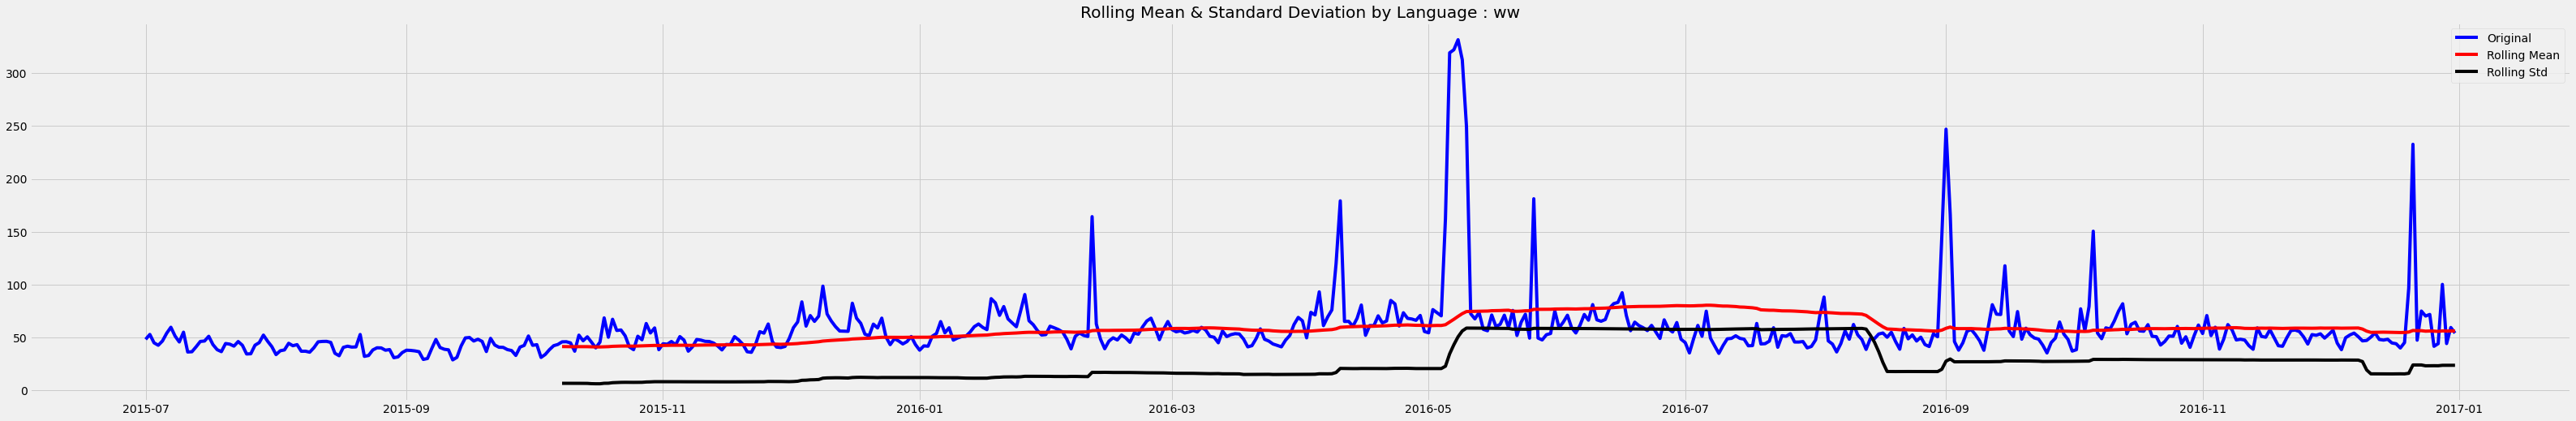

Results of Dickey-Fuller Test

Test Statistic                -6.338871e+00
p-value                        2.786556e-08
#Lags Used                     7.000000e+00
Number of Observations Used    5.420000e+02
Critical Value (1%)           -3.442473e+00
Critical Value (5%)           -2.866887e+00
Critical Value (10%)          -2.569618e+00
dtype: float64
----------------------------------------------------------------------------------------------------


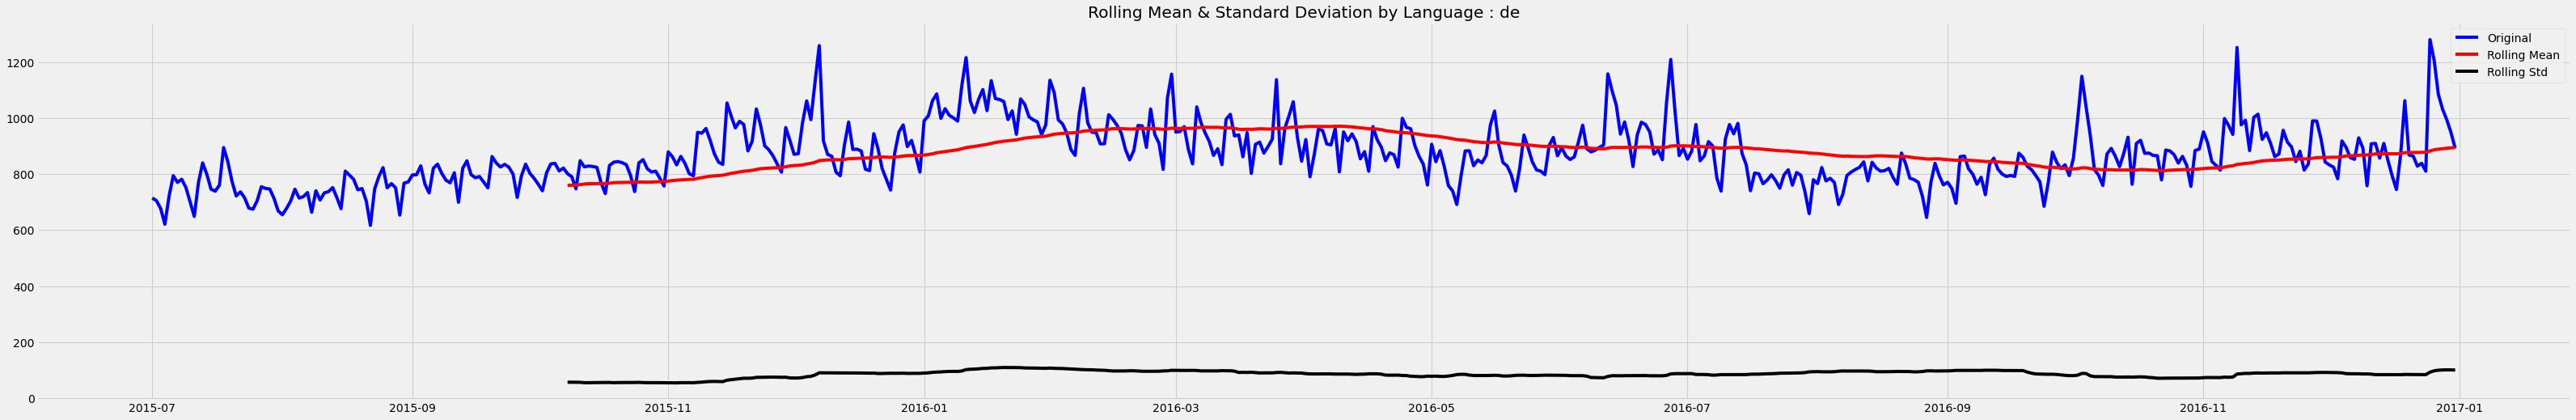

Results of Dickey-Fuller Test

Test Statistic                  -2.402707
p-value                          0.140974
#Lags Used                      16.000000
Number of Observations Used    533.000000
Critical Value (1%)             -3.442678
Critical Value (5%)             -2.866978
Critical Value (10%)            -2.569666
dtype: float64
----------------------------------------------------------------------------------------------------


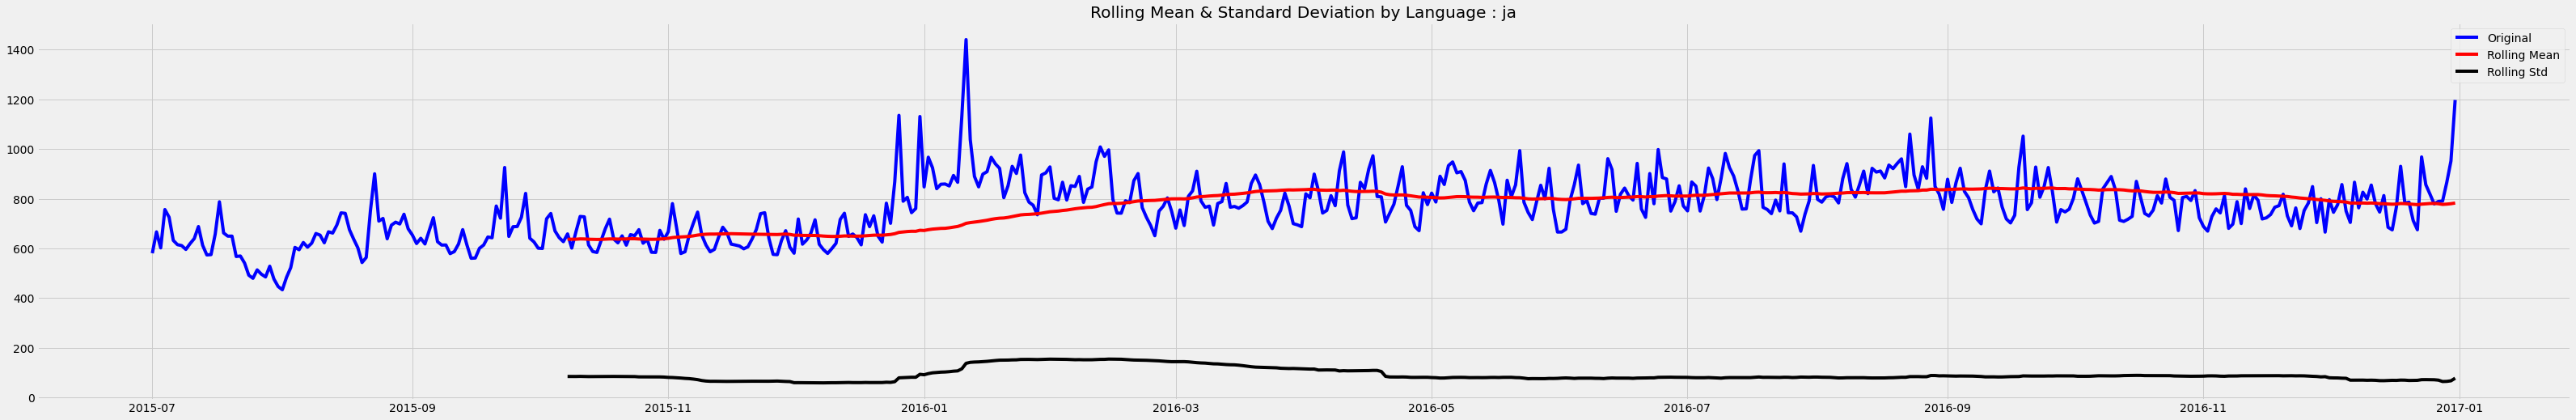

Results of Dickey-Fuller Test

Test Statistic                  -2.555394
p-value                          0.102571
#Lags Used                       8.000000
Number of Observations Used    541.000000
Critical Value (1%)             -3.442495
Critical Value (5%)             -2.866897
Critical Value (10%)            -2.569623
dtype: float64
----------------------------------------------------------------------------------------------------


In [5]:
languages = ['es', 'zh', 'fr', 'en', 'ns', 'ru', 'ww', 'de', 'ja']

for lang in languages:
    
    df = train1[train1['Language'] == lang]
    
    remove_col = ['Language', 'Name']
    pv = df.drop(remove_col, axis=1)
    
    pivot = pv.melt(id_vars='Page', var_name='Date', value_name='Visits')
    pivot['Date'] = pd.to_datetime(pivot['Date'])
    pivot.fillna(0, inplace=True)
    
    group_by = pivot[['Date', 'Visits', 'Page']].groupby(['Date'])['Visits'].mean()
    
    stationarity_test(group_by, rolling_window=100, language=lang)

* From the above graph we can conlude that the p-value of zh, en, ja is greater than 5% which means that the data is non-stationary, whereas the p-value for other languages is less than 5%, that means they are stationary.

## Auto Correlation and Partial Correlation

In [6]:
pivot = train1.drop(['Name', 'Language'], axis=1)
train_pivot = pivot.melt(id_vars='Page', var_name='Date', value_name='Visits')

In [7]:
train_pivot.head()

,Page,Date,Visits
0,2NE1_zh.wikipedia.org_all-access_spider,2015-07-01,18.0
1,2PM_zh.wikipedia.org_all-access_spider,2015-07-01,11.0
2,3C_zh.wikipedia.org_all-access_spider,2015-07-01,1.0
3,4minute_zh.wikipedia.org_all-access_spider,2015-07-01,35.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,2015-07-01,NaN


In [8]:
train_pivot.fillna(0, inplace=True)

In [9]:
train_pivot['Visits'] = train_pivot['Visits'].astype('float')

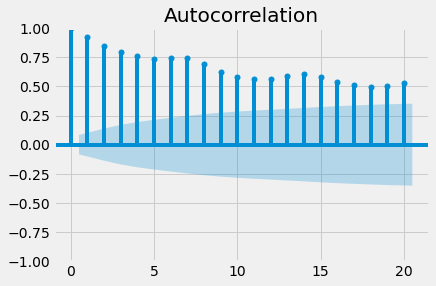

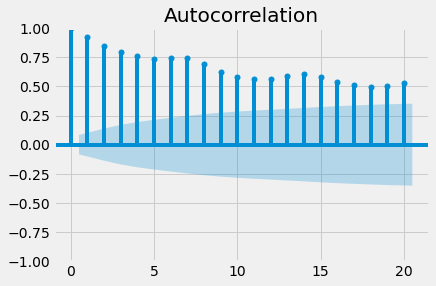

In [10]:
acf = train_pivot[['Date', 'Visits']].groupby(['Date'])['Visits'].mean()
plot_acf(acf, lags=20)

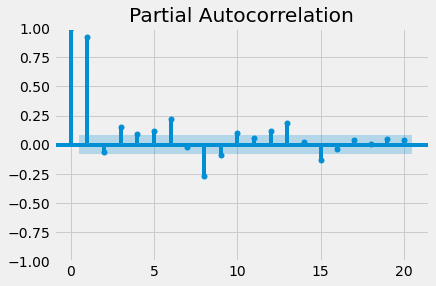

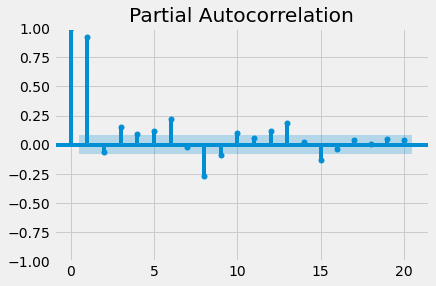

In [11]:
plot_pacf(acf, lags=20)

* We can see that there is geometric decrease in acf lags and sudden decrease in pacf after 2 lags

![AR and MA based on ACF and PACF](https://miro.medium.com/max/3000/1*MJIw0Lh2_PYMKJVTUVWAEw.png)

## Building and Testing Models

* From the above image we can see that we have geometric decrease in ACF and sudden decrease after 2 significant lags

In [12]:
# SMAPE Metric
def smape(actual, forecast):
    result = 1/len(actual) * np.sum(2*np.abs(forecast-actual) / (np.abs(actual) + np.abs(forecast))*100)
    return result

In [13]:
def plot_predictions(actual, predicted, figsize, title):
    
    plt.figure(figsize=figsize)
    actual = plt.plot(actual, color='blue', label='Actual')
    predicted = plt.plot(predicted, color='red', label='Predicted')
    plt.title(title)
    plt.legend()
    plt.show()

In [14]:
data = train1.drop(['Page', 'Name', 'Language'], axis=1)
data.fillna(0, inplace=True)

### AR Model

In [15]:
from statsmodels.tsa.ar_model import AutoReg

In [16]:
def AutoRegression(data, lags, test_days, visualize_prediction:bool=False):
    
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data.reshape(-1, 1))
    
    train = scaled_data[:-test_days]
    test = scaled_data[-test_days:]
    
    ar = AutoReg(train, lags=lags)
    model = ar.fit()
    
    # Predict
    ## Training predictions
    train_start = 0
    train_end = len(train)
    train_pred = model.predict(start=train_start, end=train_end)
    
    ## Testing predictions
    test_start = len(train)
    test_end = len(train) + len(test)
    test_pred = model.predict(start=test_start, end=test_end)
    
    ## Inverse transform
    train_inverse = scaler.inverse_transform(train_pred.reshape(-1, 1))
    test_inverse = scaler.inverse_transform(test_pred.reshape(-1, 1))
    
    # Plot predictions
    if visualize_prediction:
        plot_predictions(train, train_pred, figsize=(20, 6), title='AR Trainig (In Fold) Predictions')
        plot_predictions(test, test_pred, figsize=(20, 6), title='AR Testing (Out of Fold) Predictions')
    
    train_error = smape(train, train_pred)
    test_error = smape(test, test_pred)
    
    print(f'Train Error: {train_error} | Test Error: {test_error}')

    return model

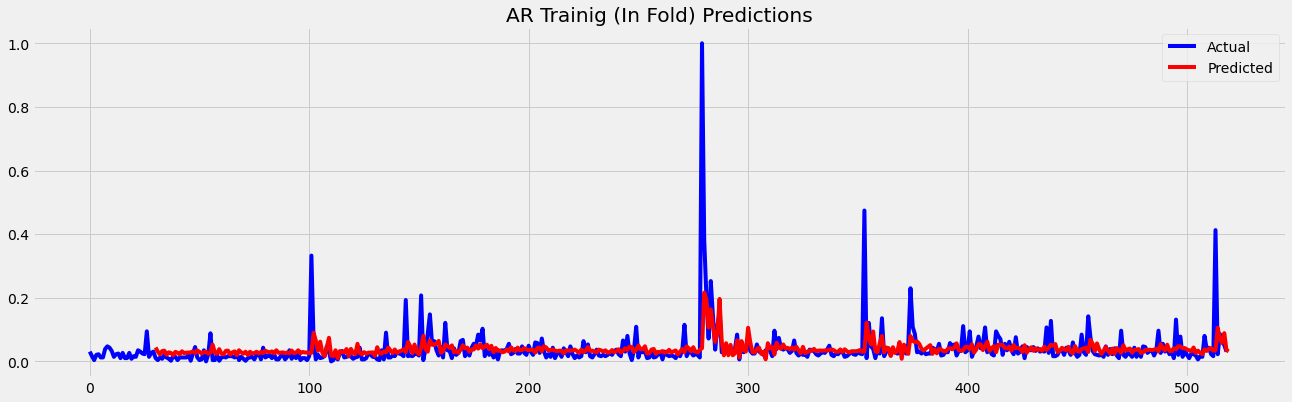

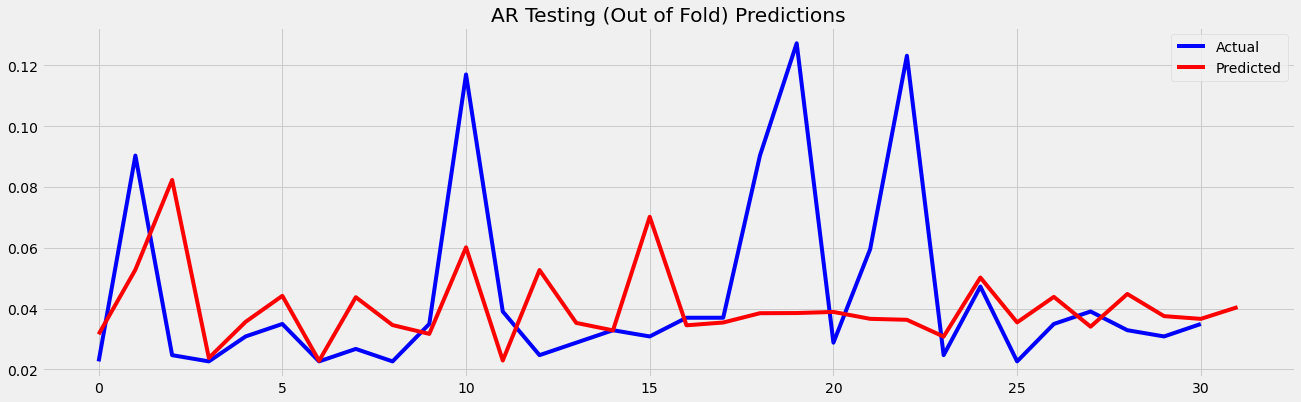

Train Error: nan | Test Error: 1367.1588631346135


In [17]:
train = data.iloc[0, :].values
model = AutoRegression(train, 30, 31, True)

### ARIMA

In [18]:
from statsmodels.tsa.arima.model import ARIMA

In [20]:
def Arima(data, p, d, q, test_days, visualize_predictions=False):

    train_date = data[:-31]
    test_date = data[-31:]

    data = data.astype('float')
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))

    #scaled_data.index = pd.to_datetime(data.index)
    train = scaled_data[:-31]
    test = scaled_data[-31:]

    #print(train), print(type(train)), print(train.shape), print(len(train))
    train = pd.Series(train.reshape(len(train)), index=pd.to_datetime(train_date.index))
    test = pd.Series(test.reshape(len(test)), index=pd.to_datetime(test_date.index))

    arima = ARIMA(train, order=[p, d, q])
    model = arima.fit()

    # Predict
    ## Training predictions
    train_start = 0
    train_end = len(train)
    train_pred = model.predict(start=train_start, end=train_end, typ='levels')

    ## Testing predictions
    test_start = len(train)
    test_end = len(train) + len(test) - 1
    test_pred = model.predict(start=test_start, end=test_end, typ='levels')

    # Inverse transform
    train_inverse = scaler.inverse_transform(np.array(train_pred).reshape(-1, 1))
    test_inverse = scaler.inverse_transform(np.array(test_pred).reshape(-1, 1))

    #print(test_pred)

    if visualize_predictions:
        plot_predictions(train, train_pred, (20, 5), 'ARIMA Training Predictions')
        plot_predictions(test, test_pred, (20, 5), 'ARIMA Testing Predictions')
    
    train_error = smape(train, train_pred)
    test_error = smape(test, test_pred)
    
    print(f'Train Error: {train_error} | Test Error: {test_error}')
    
    return model

In [21]:
row = data.iloc[0, :]

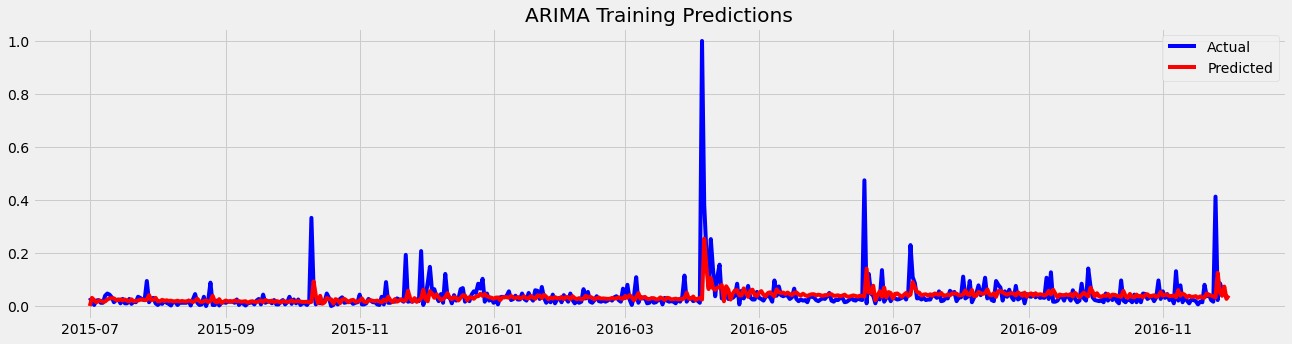

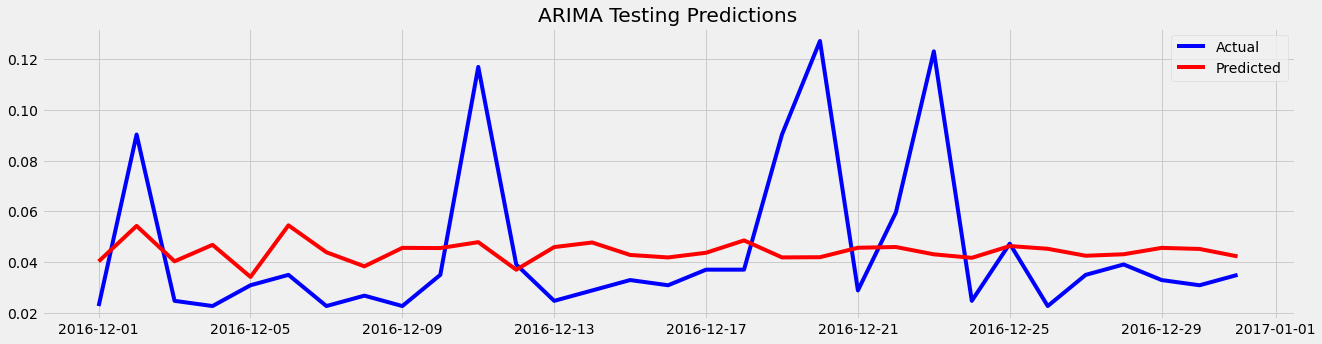

Train Error: 55.72481838332769 | Test Error: 43.58636151277333


In [22]:
model = Arima(row, 5, 1, 5, 31, visualize_predictions=True)

### Prophet

In [24]:
from prophet import Prophet

In [25]:
def prophet(data, test_days, visualize_predictions, plot_prophet_comp:bool=False):
    
    train_date = data[:-test_days]
    test_date = data[-test_days:]
    
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))
    
    train = scaled_data[:-test_days]
    test = scaled_data[-test_days:]
    
    df = pd.DataFrame({'ds':pd.to_datetime(train_date.index), 'y':train.reshape(len(train))})
    
    model = Prophet()
    model.fit(df)
    
    
    future = model.make_future_dataframe(periods=test_days)
    forecast = model.predict(future)
    
    train_actual = pd.Series(train.reshape(len(train)), index=pd.to_datetime(train_date.index))
    train_pred = pd.Series(forecast.yhat.values[:-test_days].reshape(len(train)), index=pd.to_datetime(train_date.index))
    
    test_actual = pd.Series(test.reshape(len(test)), index=pd.to_datetime(test_date.index))
    test_pred = pd.Series(forecast.yhat.values[-test_days:].reshape(len(test)), index=pd.to_datetime(test_date.index))
    
    # Visualize Predictions
    if visualize_predictions:
        plot_predictions(train_actual, train_pred, title='Prophet In Fold Predictions', figsize=(20, 5))
        plot_predictions(test_actual, test_pred, title='Prophet Out of Fold Predictions', figsize=(20, 5))
    
    if plot_prophet_comp:
        fig1 = model.plot(forecast)
        fig2 = model.plot_components(forecast)
    
    train_error = smape(train_actual, train_pred)
    test_error = smape(test_actual, test_pred)
    
    print(f'Train Error: {train_error} | Test Error: {test_error}')
    
    return model

13:55:14 - cmdstanpy - INFO - Chain [1] start processing
13:55:14 - cmdstanpy - INFO - Chain [1] done processing


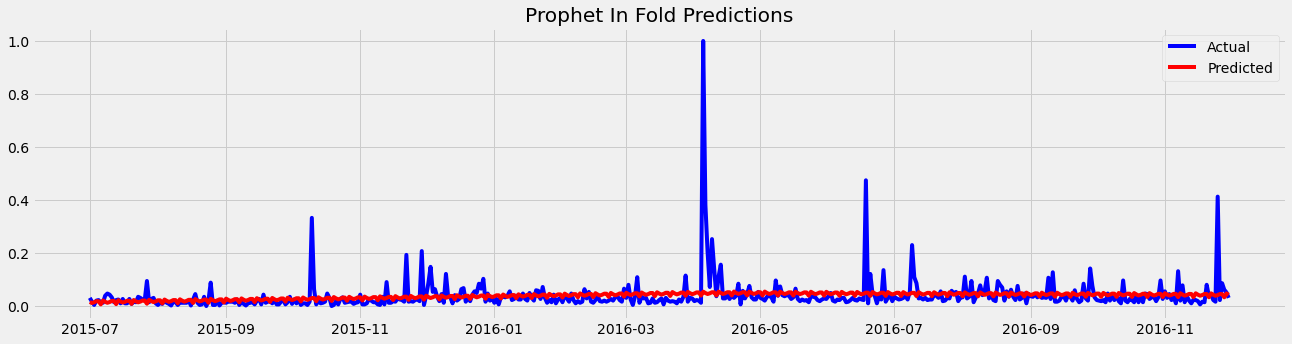

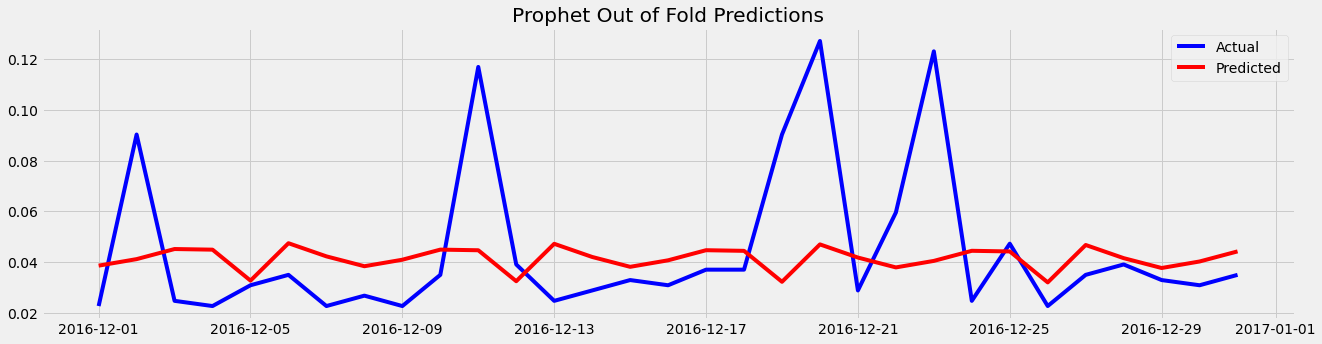

Train Error: 61.29830892369512 | Test Error: 42.62278890942475


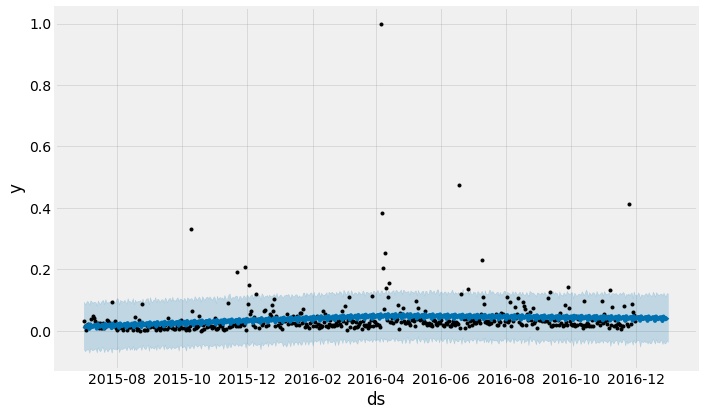

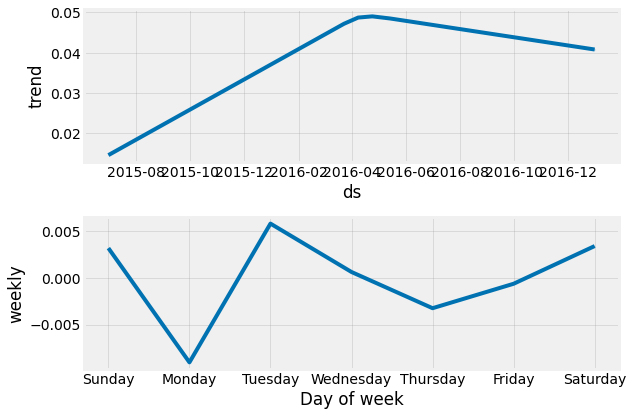

In [26]:
row_p = data.iloc[0, :]
model_prophet = prophet(row_p, 31, True, True)

## LSTM

In [27]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras import Sequential
from sklearn.metrics import mean_squared_error

In [28]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i+look_back, 0])
    return np.array(dataX), np.array(dataY)

In [29]:
def Lstm(x_train, y_train, input_shape, num_lstm, epochs):
    
    model = Sequential()
    model.add(LSTM(num_lstm, input_shape=input_shape))
    model.add(Dense(1))
    
    model.compile(
        loss='mean_squared_error',
        optimizer='adam'
    )
    
    es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
    
    model.fit(x_train, y_train, epochs=epochs, batch_size=1, verbose=0, callbacks=[es])
    
    return model

In [30]:
def run_lstm(data, num_lstm, epochs, visualize_predictions=False):

    # Scale the visits
    scaler = MinMaxScaler()
    scaled_row = scaler.fit_transform(np.array(data).reshape(-1, 1))
    
    # split into training and testing
    train_data = scaled_row[:-31]
    test_data = scaled_row[-31:]
    
    # Transform the dataset
    x_train, y_train = create_dataset(train_data.reshape(-1, 1))
    x_test, y_test = create_dataset(test_data.reshape(-1, 1))
    
    # Reshape the data for the lstm model
    x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
    x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

    model = Lstm(x_train, y_train, (1, 1), num_lstm, epochs)

    # test the model
    train_pred = model.predict(x_train)
    test_pred = model.predict(x_test)
    
    train_pred_inverse = scaler.inverse_transform(train_pred)
    train_true_inverse = scaler.inverse_transform([y_train])
    test_pred_inverse = scaler.inverse_transform(test_pred)
    test_true_inverse = scaler.inverse_transform([y_test])
    
    if visualize_predictions:
        plot_predictions(y_train.reshape(-1, 1), train_pred, figsize=(20, 5), title='LSTM Training Predictions')
        plot_predictions(y_test.reshape(-1, 1), test_pred, figsize=(20, 5), title='LSTM Testing Predictions')
    
    # Error
    train_error_mae = mean_squared_error(y_train.reshape(-1, 1), train_pred)
    test_error_mae = mean_squared_error(y_test.reshape(-1, 1), test_pred)
    
    train_error_smape = smape(y_train, train_pred)
    test_error_smape = smape(y_test, test_pred)
    
    print('Mean Squared Error')
    print(f'Train Error: {train_error_mae} | Test Error: {test_error_mae}')
    print('-' * 100)
    print('SMAPE')
    print(f'Train Error: {train_error_smape} | Test Error: {test_error_smape}')
    
    return model

1/1 [==============================] - 0s 25ms/step


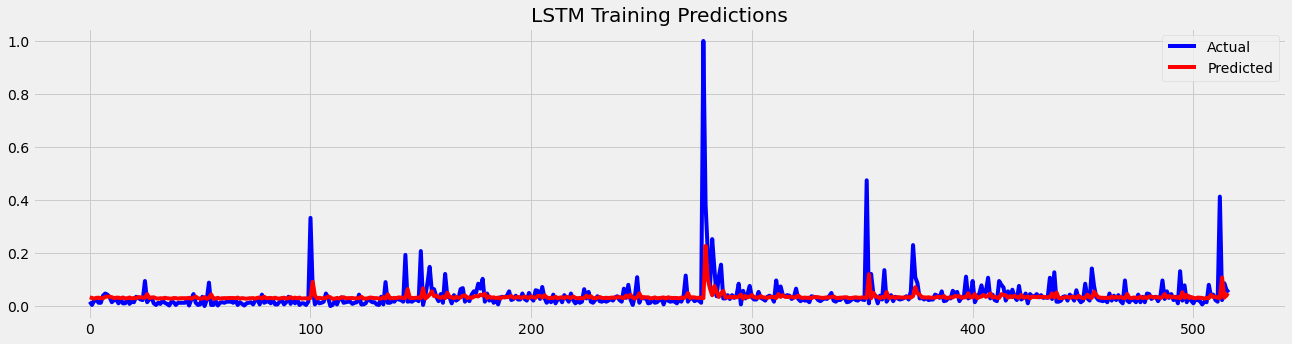

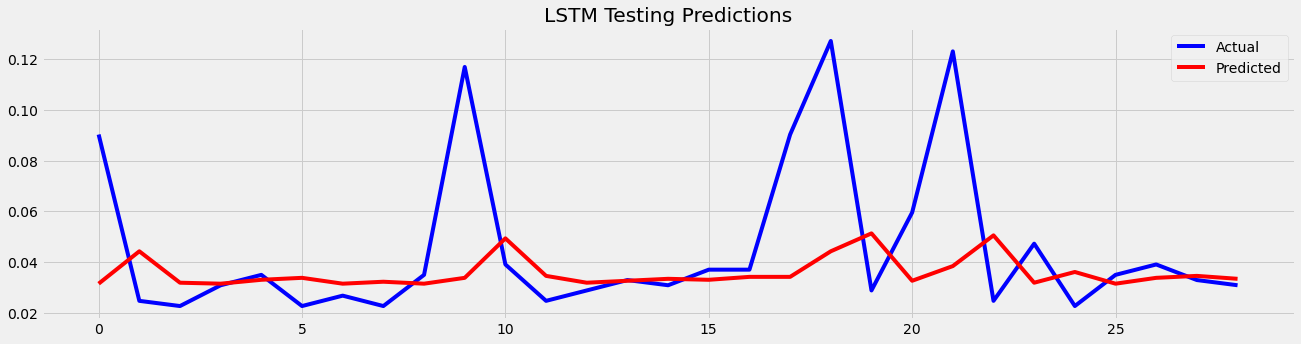

Mean Squared Error
Train Error: 0.0036344224042717975 | Test Error: 0.0010695194486599973
----------------------------------------------------------------------------------------------------
SMAPE
Train Error: 30739.368992804397 | Test Error: 1086.963770257652


In [31]:
row = data.iloc[0, :]
model_lstm = run_lstm(row, 10, 10, True)